In [1]:
import pyodbc
import re
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import seaborn as sns
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
import tensorflow as tf
from sklearn.linear_model import Perceptron
from tensorflow import keras

# 1. Data visualization

In [2]:
# importing required modules

# specifying the zip file name
file_name = "digit-recognizer.zip"

# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()

    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')


File Name                                             Modified             Size
sample_submission.csv                          2019-12-11 20:01:20       240909
test.csv                                       2019-12-11 20:01:20     51118296
train.csv                                      2019-12-11 20:01:24     76775041
Extracting all the files now...
Done!


In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train = train_df.loc[:, train_df.columns != 'label'].values
train_ar = np.empty((28,28,42000))

for m in range(42000):#digit
    for i in range(28):#rows
        for j in range(28):#columns
            train_ar[i][j][m] = X_train[m,i*28+j]

now train_ar has a three dimensional array: 28x28x42000. I want to display all the digits one next to the other. There are 42000 digits, we can put then in 200 columns and 210 rows. Then we need an array of size (210x28, 200x28)

In [6]:
img_train_digits = np.empty((28,5628))
col = np.empty((28,28))
row_cnt = 0
px_cnt = 0
for m in range(42000):
    px_cnt+=1
    col = np.hstack((col, train_ar[:,:,m]))#putting 200 digits one after the other, from the left to the right
    if(px_cnt%200==0):#now I have a row of 200 digits, so I'm going to stack a row on top of the other
        if(row_cnt==0):
            img_train_digits = col
        else:
            img_train_digits = np.vstack((img_train_digits, col))#stacking rows of 200 digits until I run out of digits
        row_cnt+=1
        col = np.empty((28,28))#this is the first element of each row, I made it so I have something to start making each row. Feeling cute now, might delete late

img_train_digits = img_train_digits[:,29:]#...deleted

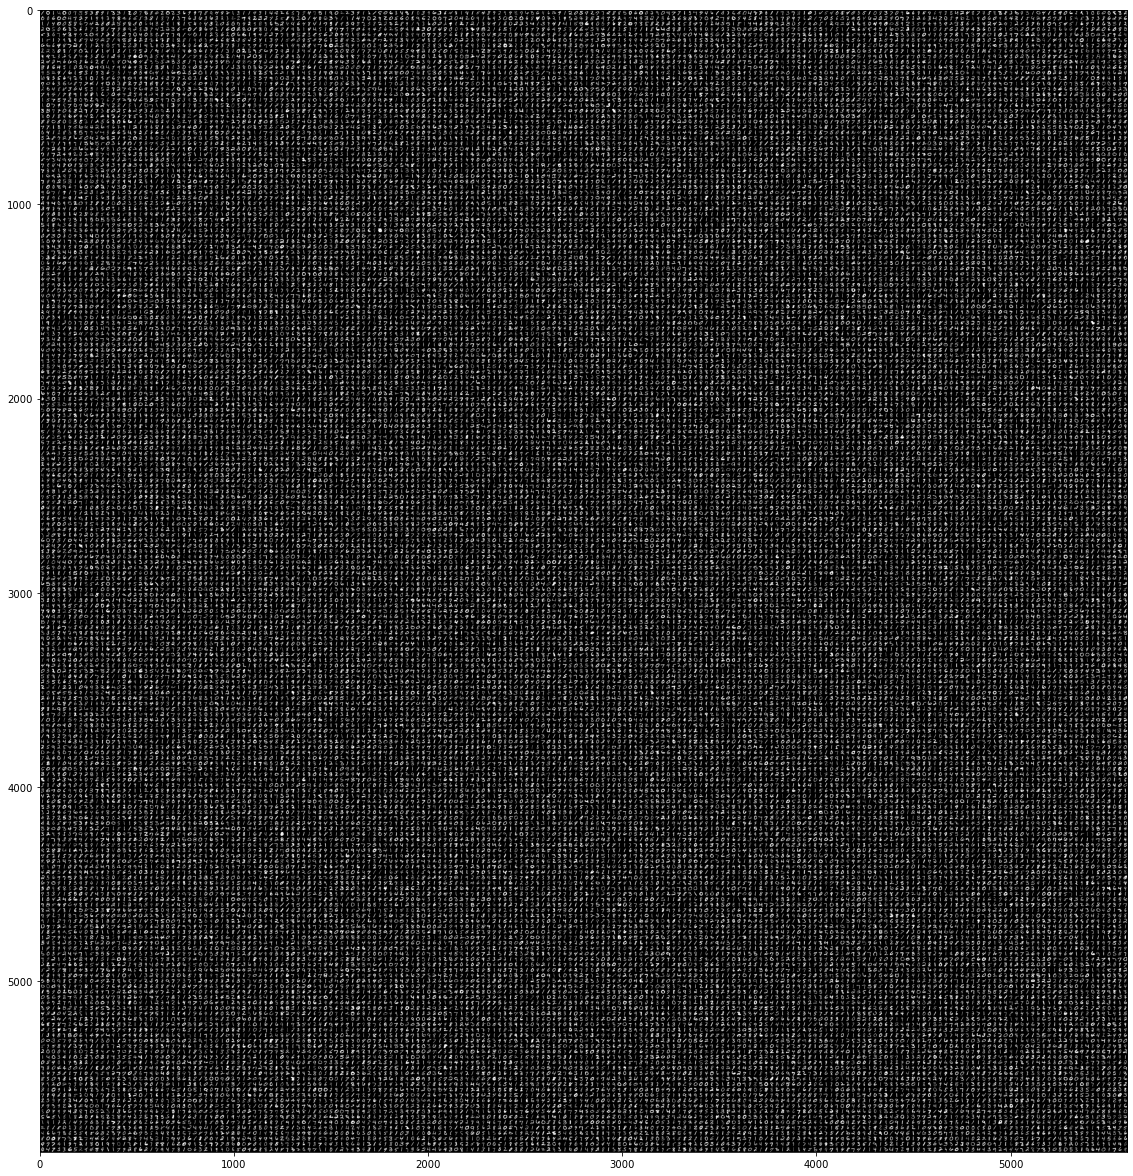

In [130]:
gr_im= Image.fromarray(img_train_digits)
plt.figure(figsize=(20, 21))
plt.imshow(gr_im)

# 2. First solution: Deskewing + pairwise linear classifier

## Deskewing

In [128]:
train_ar.shape

(28, 28, 42000)

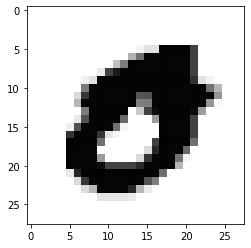

In [175]:
digit = 555
plt.imshow(train_ar[:,:,digit], cmap='Greys')

In [176]:
# Find all contours
image = train_ar[:,:,digit].astype("uint8")
contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)
# Find largest contour and surround in min area box
largestContour = contours[0]
minAreaRect = cv2.minAreaRect(largestContour)
minAreaRect

((13.794116973876953, 14.323528289794922),
 (16.120866775512695, 21.951818466186523),
 59.036251068115234)

In [177]:
box = cv2.boxPoints(minAreaRect)
box = np.int0(box)

In [178]:
box

array([[ 0, 13],
       [19,  1],
       [27, 15],
       [ 8, 26]], dtype=int64)

correcting angle

In [179]:
#calculate angle that needs to be compensated
if(np.linalg.norm(box[0]-box[1])>np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]<=45):
       angle = minAreaRect[-1]
elif(np.linalg.norm(box[0]-box[1])<np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]>=45):
       angle = minAreaRect[-1] - 90
if(np.linalg.norm(box[0]-box[1])<=np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]<45):
       angle = minAreaRect[-1]
elif(np.linalg.norm(box[0]-box[1])>=np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]>45):
       angle = minAreaRect[-1] - 90
if(np.linalg.norm(box[0]-box[1])==np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]==45):
       angle = minAreaRect[-1]

In [180]:
newImage = image.copy()
(h, w) = newImage.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

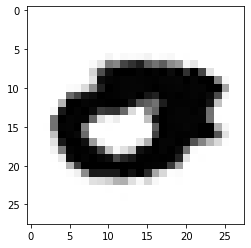

In [181]:
plt.imshow(newImage, cmap='Greys')

Now lets apply it all and make the new data set

In [79]:
def deskewing(image):
    image = image.astype("uint8")
    # Find all contours
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)
    box = cv2.boxPoints(minAreaRect)
    box = np.int0(box)

    #calculate angle that needs to be compensated
    if(np.linalg.norm(box[0]-box[1])>np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]<=45):
           angle = minAreaRect[-1]
    elif(np.linalg.norm(box[0]-box[1])<np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]>=45):
           angle = minAreaRect[-1] - 90
    if(np.linalg.norm(box[0]-box[1])<=np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]<45):
           angle = minAreaRect[-1]
    elif(np.linalg.norm(box[0]-box[1])>=np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]>45):
           angle = minAreaRect[-1] - 90
    if(np.linalg.norm(box[0]-box[1])==np.linalg.norm(box[0]-box[3]) and minAreaRect[-1]==45):
           angle = minAreaRect[-1]
    #compensate for the angle found
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    try: 
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
    except:
        print('nope', minAreaRect[-1],np.linalg.norm(box[0]-box[1]),np.linalg.norm(box[0]-box[3]))
    newImage = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    newImage = newImage.flatten()

    return newImage

In [80]:
train_rows_list = []
for i in range(train_df.shape[0]):
    flat_train = train_df.loc[:, train_df.columns != 'label'].iloc[i].values
    train_ = np.empty((28,28))
    for i in range(28):#rows
        for j in range(28):#columns
            train_[i][j] = flat_train[i*28+j]
            
    train_rows_list.append(deskewing(train_))


In [87]:
train_rows_df = pd.DataFrame(train_rows_list, columns = train_df.columns[train_df.columns!='label'])
train_rows_df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
test_row_list = []
for i in range(test_df.shape[0]):
    flat_test = test_df.iloc[i].values
    test_ = np.empty((28,28))
    for i in range(28):#rows
        for j in range(28):#columns
            test_[i][j] = flat_test[i*28+j]
            
    test_row_list.append(deskewing(test_))

In [92]:
test_rows_df = pd.DataFrame(test_row_list, columns = test_df.columns)
test_rows_df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Pairwise linear classifier

https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
X_train = train_df.loc[:, train_df.columns != 'label'].values
y_train = train_df['label'].values
X_test = test_df.values

with preprocessing

In [200]:
X_train = train_rows_df.values[:35000]
y_train = train_df['label'].values[:35000]

In [201]:
X_test = train_rows_df.values[35000:]
y_test = train_df['label'].values[35000:]

In [202]:
X_train.shape

(35000, 784)

In [204]:
clf = OneVsOneClassifier(
    Perceptron()).fit(X_train, y_train)#Perceptron(tol=1e-3, random_state=0)

In [205]:
clf.score(X_test,y_test)

0.9028571428571428

without preprocessing

In [9]:
X_train = train_df.loc[:, train_df.columns != 'label'].values[:35000]
y_train = train_df['label'].values[:35000]
X_test = train_df.loc[:, train_df.columns != 'label'].values[35000:]
y_test = train_df['label'].values[35000:]

In [213]:
clf = OneVsOneClassifier(
    Perceptron()).fit(X_train, y_train)#Perceptron(tol=1e-3, random_state=0)

In [214]:
clf.score(X_test,y_test)

0.9165714285714286

In [ ]:
#theory: without deskewing the average position of black pixels tends to be the same than after skewing

# 3. Convolutional neural network

make array of (42000,28,28,1)

In [52]:
X_train = train_df.loc[:, train_df.columns != 'label'].values
all_ar = np.empty((42000,28,28,1))

for m in range(42000):#digit
    for i in range(28):#rows
        for j in range(28):#columns
            all_ar[m][i][j][0] = X_train[m,i*28+j]

In [54]:
x_train = all_ar[:30000,:,:,:]
y_train = train_df['label'].values[:30000]

x_val = all_ar[30000:35000,:,:,:]
y_val = train_df['label'].values[30000:35000]

x_test = all_ar[35000:42000,:,:,:]
y_test = train_df['label'].values[35000:42000]

In [113]:
def preprocess(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.int64)
    return x, y

def create_dataset(xs, ys, n_classes=10):
    
    ys = tf.one_hot(ys, depth=n_classes)
    return tf.data.Dataset.from_tensor_slices((xs, ys)) \
        .map(preprocess) \
        .shuffle(len(ys)) \
        .batch(200)

In [114]:
train_dataset = create_dataset(x_train, y_train)
val_dataset = create_dataset(x_val, y_val)
test_dataset = create_dataset(x_test, y_test)

In [117]:
model1 = keras.Sequential([
    keras.layers.Conv2D(100, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28,28,1)),#input_shape is  (batch, rows, cols, channels) if data_format is "channels_last".
    
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(100, (3, 3), activation='relu', kernel_initializer='he_uniform'),#input_shape is  (batch, rows, cols, channels) if data_format is "channels_last".
    
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(100, (3, 3), activation='relu', kernel_initializer='he_uniform'),#input_shape is  (batch, rows, cols, channels) if data_format is "channels_last".
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(
      units=100, activation='relu',  kernel_initializer='he_uniform'
    ),
    
    keras.layers.Dense(
      units=10, activation = 'softmax'
    )
])

#Conv2D(5, (3, 3), activation='relu', input_shape=(28,28))# filters, kernel_size 
#model.add(layers.MaxPooling2D((2, 2)))

##########################################################################################################################################################
model1.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

##########################################################################################################################################################
history = model1.fit(
    train_dataset.repeat(),
    epochs=50,
    steps_per_epoch=150,#train samples / batch size
    validation_data = val_dataset.repeat(),
    validation_steps=25#validation samples / batch size
)

Epoch 1/50
150/150 [==============================] - 3s 19ms/step - loss: 2.1816 - accuracy: 0.3133 - val_loss: 2.0540 - val_accuracy: 0.5010
Epoch 2/50
150/150 [==============================] - 3s 18ms/step - loss: 1.9121 - accuracy: 0.6466 - val_loss: 1.8090 - val_accuracy: 0.7450
Epoch 3/50
150/150 [==============================] - 3s 18ms/step - loss: 1.7443 - accuracy: 0.7864 - val_loss: 1.7109 - val_accuracy: 0.8018
Epoch 4/50
150/150 [==============================] - 3s 18ms/step - loss: 1.6895 - accuracy: 0.8135 - val_loss: 1.6788 - val_accuracy: 0.8176
Epoch 5/50
150/150 [==============================] - 3s 18ms/step - loss: 1.6663 - accuracy: 0.8255 - val_loss: 1.6611 - val_accuracy: 0.8278
Epoch 6/50
150/150 [==============================] - 3s 18ms/step - loss: 1.6524 - accuracy: 0.8334 - val_loss: 1.6488 - val_accuracy: 0.8328
Epoch 7/50
150/150 [==============================] - 3s 18ms/step - loss: 1.6142 - accuracy: 0.8833 - val_loss: 1.5950 - val_accuracy: 0.9046

In [87]:
def plot_metrics(metric1, metric2):
    fig = go.Figure()
    x = np.arange(0,len(history.history[metric1]),1)
    y1 = history.history[metric1]
    y2 = history.history[metric2]
    # Add traces
    fig.add_trace(go.Scatter(x=x, y=y1,
                        mode='lines', marker = dict(size=6, color = '#D100FF'),
                        name=metric1))
    fig.add_trace(go.Scatter(x=x, y=y2,
                        mode='lines', marker = dict(size=6, color = '#1BFF00'),
                        name=metric2))
    fig.update_layout(title=metric1+' and '+metric2, width=800, height=400,
                      xaxis = dict(title = 'Epoch'))


    return fig

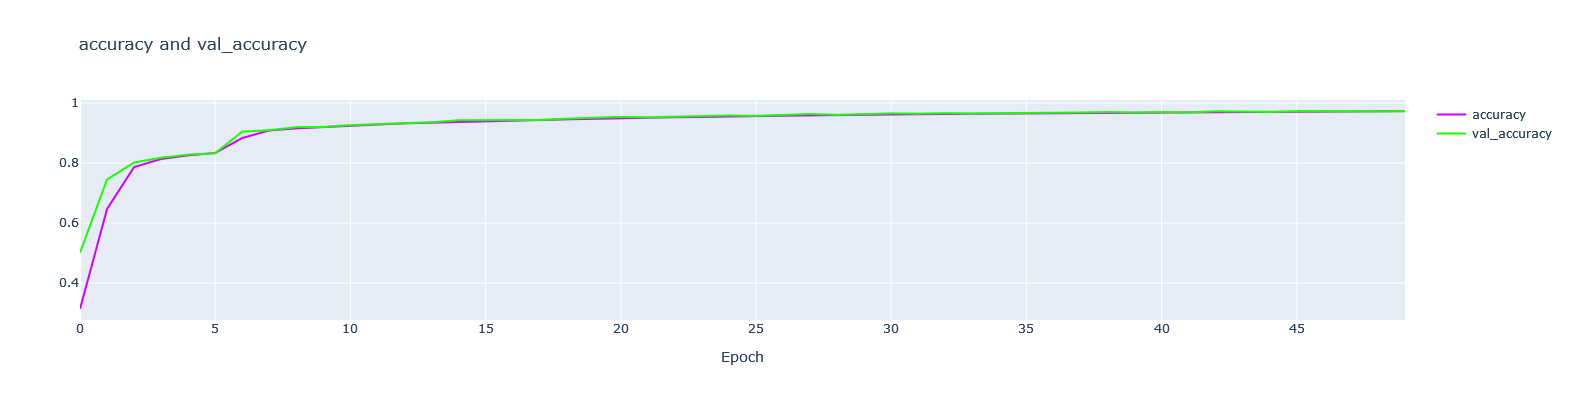

In [118]:
plot_metrics('accuracy','val_accuracy')

In [121]:
test_loss, test_acc = model1.evaluate(test_dataset, verbose=2)

35/35 - 0s - loss: 1.4984 - accuracy: 0.9696


# 4. Showing off here. Look, it works!

In [174]:
X_test = test_df.loc[:, test_df.columns].values
test_ar = np.empty((test_df.shape[0],28,28,1))

for m in range(test_df.shape[0]):#digits
    for i in range(28):#rows
        for j in range(28):#columns
            test_ar[m][i][j][0] = X_test[m,i*28+j]

In [189]:
test_ar.shape

(28000, 28, 28, 1)

Real Number


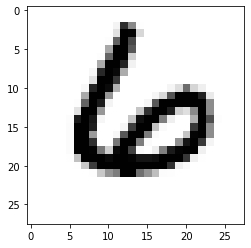

Prediction: 
6
Real Number


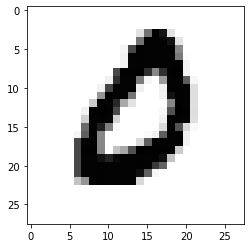

Prediction: 
0
Real Number


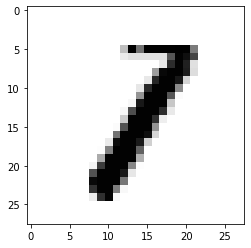

Prediction: 
1
Real Number


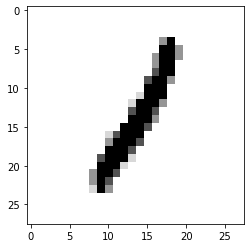

Prediction: 
1
Real Number


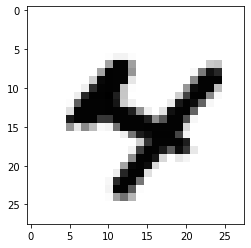

Prediction: 
4
Real Number


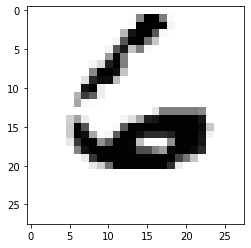

Prediction: 
6
Real Number


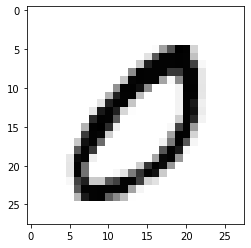

Prediction: 
0
Real Number


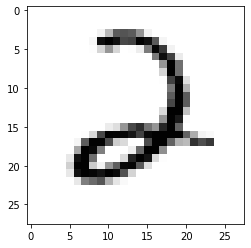

Prediction: 
2
Real Number


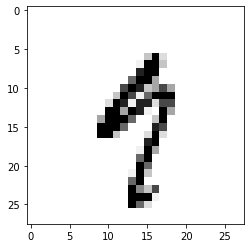

Prediction: 
4
Real Number


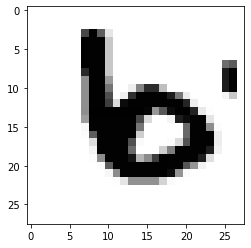

Prediction: 
6


In [193]:
for i in range(10):#test_df.shape[0]
    print('Real Number')
    digit = np.random.randint(0,X_test.shape[0]-1)
    plt.imshow(test_ar[digit,:,:,:], cmap='Greys')   
    plt.show()
    x_test = np.empty((1,28,28,1))#batch of 1 sample, rows, columns, channels
    for m in range(28):#rows
        for n in range(28):#columns
            x_test[0][m][n][0] = X_test[digit,m*28+n]
    x_test = tf.cast(x_test, tf.float32)/255
    print('Prediction: ')
    print(model1.predict(x_test).argmax())
    

In [195]:

result = model1.predict(test_ar)

In [196]:
Label = []
for i in result:
    Label.append(np.argmax(i))

In [205]:
results_df = pd.DataFrame({'ImageId':[i for i in range(1,28001)],'Label':Label})
results_df.to_csv('results.csv', index=False)

In [199]:
l = [i for i in range(25,35)]
l

[25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

In [204]:
[i for i in range(1,28001)][-1]

28000